# Foreign Student Mental Health ML

This project uses machine learning techniques to learn about influences on mental health of international and domestic students at Ritsumeikan Asia Pacific University in Japan and aims to build a model to predict students at risk of mental health issues such as depression and suicidal ideation.

Notes on the data
* Two of the international students have country of origin as Japan, meaning they lived abroad and then applied to the university as an international student. These students were regarded as international in the analysis.

## Notebook WIP Notes
This cell contains notes and todos on the progress of this project for reference purposes, and is intended for deletion when the notebook is complete.

**Progress Outside of Notebook**
* Codebook Excel corrected so that it is consistent with the actual data, by using value_counts to observe actual values of cat cols.


**TODO, IMMEDIATE:**
* Include the numeric and categorical TARGETS in the dtype correcting and checking step (alongside the features)

**TODO (non-immediate):**
* Add a link to the readme and the top of this notebook for downloading the actual data (to show I didn't edit it)

## 1. Imports and Configuration

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# ML imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    roc_auc_score,
    precision_recall_curve,
    auc,
)

from sklearn.inspection import permutation_importance
import xgboost as xgb
import shap

# Other
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from pandas.api.types import is_numeric_dtype

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# File paths
DATA_PATH = Path("../data/data.csv")
CODEBOOK_PATH = Path("../data/feature_target_explanations.xlsx")

# Toggles
INCLUDE_FSCORE2 = False  # set True to include feature-score == 2 variables
# FLAGGING FOR LATER: Consider removing
SHAP_SAMPLE_N = 300  # sample size for SHAP
SHAP_TOP_K = 5  # how many top features to explain with SHAP

## 2. Data Prep and Cleaning

### Quick file existence check and preview

In [2]:
print("Data exists:", DATA_PATH.exists())
print("Codebook exists:", CODEBOOK_PATH.exists())

data = pd.read_csv(DATA_PATH)
print("Data shape:", data.shape)
display(data.head())

Data exists: True
Codebook exists: True
Data shape: (268, 50)


,inter_dom,Region,Gender,Academic,Age,Age_cate,Stay,Stay_Cate,Japanese,Japanese_cate,...,Friends_bi,Parents_bi,Relative_bi,Professional_bi,Phone_bi,Doctor_bi,religion_bi,Alone_bi,Others_bi,Internet_bi
0,Inter,SEA,Male,Grad,24,4,5,Long,3,Average,...,Yes,Yes,No,No,No,No,No,No,No,No
1,Inter,SEA,Male,Grad,28,5,1,Short,4,High,...,Yes,Yes,No,No,No,No,No,No,No,No
2,Inter,SEA,Male,Grad,25,4,6,Long,4,High,...,No,No,No,No,No,No,No,No,No,No
3,Inter,EA,Female,Grad,29,5,1,Short,2,Low,...,Yes,Yes,Yes,Yes,No,No,No,No,No,No
4,Inter,EA,Female,Grad,28,5,1,Short,1,Low,...,Yes,Yes,No,Yes,No,Yes,Yes,No,No,No


### Load codebook and inspect - is this necessary?

In [3]:
cb_numeric = pd.read_excel(CODEBOOK_PATH, sheet_name="numeric_variables")
cb_categorical = pd.read_excel(CODEBOOK_PATH, sheet_name="cat_variables")
display(cb_numeric.head())
display(cb_categorical.head())

,Coded Name,Feature Score,Target Score,Filter Score,Explanation,Unit,Mean,Min,Max,Standard Deviation
0,Age,3,0,2,Current age of students,Year,20.87,17,31,2.77
1,Stay,3,0,2,How long they have been in the university,Year,2.15,1,10,1.33
2,Japanese,3,0,2,Self-evaluation scale ranging from 1 to 5 rega...,Count,3.10,1,5,1.31
3,English,3,0,2,Self-evaluation scale ranging from 1 to 5 rega...,Count,3.65,1,5,0.88
4,ToDep,0,3,1,Total score of depression measured by PHQ-9,Count,8.19,0,25,4.95


,Coded Name,Numeric Version Exists,Feature Score,Target Score,Filter Score,Explanation,Possible Values
0,inter_dom,N,3,0,3,Types of students: International student (Inte...,"Inter, Dom"
1,Region,N,1,0,2,Regions where students originally come from: J...,"JAP, EA, SA, SEA, Others"
2,Gender,N,3,0,1,Gender of students: Male or Female,"Male, Female"
3,Academic,N,3,0,1,The current academic level of students: Underg...,"Under, Grad"
4,Age_cate,Y,3,0,1,The age group of students at time of taking th...,"1, 2, 3, 4, 5"


### Rename and define targets

Rename the targets to improve clarity.

In [4]:
# OLD VERSION OF TARGETS:
# TARGETS = {"depression": "ToDep", "ideation": "Suicide", "acculturative_stress": "ToAS"}

# New target variable names
rename_targets = {
    "ToDep": "depression",
    "Suicide": "suicidal_ideation",
    "ToAS": "acculturative_stress",
}

# Update data columns
data = data.rename(columns=rename_targets)

# Update codebooks
cb_numeric["Coded Name"] = cb_numeric["Coded Name"].replace(rename_targets)
cb_categorical["Coded Name"] = cb_categorical["Coded Name"].replace(rename_targets)

# Define target lists
TARGETS = list(rename_targets.values())

NUMERIC_TARGETS = [
    target for target in rename_targets.values() if target in cb_numeric["Coded Name"].values
]

CAT_TARGETS = [
    target for target in rename_targets.values() if target in cb_categorical["Coded Name"].values
]

print(f"Numeric targets: {len(NUMERIC_TARGETS)}, {NUMERIC_TARGETS}")
print(f"Categorical targets: {len(CAT_TARGETS)}, {CAT_TARGETS}")

Numeric targets: 2, ['depression', 'acculturative_stress']
Categorical targets: 1, ['suicidal_ideation']


### Clean variable names

In [5]:
def clean_up(input: pd.Index | pd.Series) -> pd.Index | pd.Series:
    """Cleans by stripping whitespace, converting to lowercase,
    and replacing spaces with underscores."""
    return input.str.strip().str.lower().str.replace(" ", "_", regex=False)


# Clean columns in data
data.columns = clean_up(data.columns)

# Clean columns in codebook
cb_numeric.columns = clean_up(cb_numeric.columns)
cb_categorical.columns = clean_up(cb_categorical.columns)

# Clean variables in codebook
cb_numeric["coded_name"] = clean_up(cb_numeric["coded_name"])
cb_categorical["coded_name"] = clean_up(cb_categorical["coded_name"])

### Ensure consistency
Verify that codebook variables match the data column names exactly by symmetric difference "^".

In [6]:
codebook_vars_set = set(cb_numeric["coded_name"]) | set(cb_categorical["coded_name"])
variable_mismatch = set(data.columns) ^ codebook_vars_set
assert (
    len(variable_mismatch) == 0
), f"The following variables mismatch between codebook and data: {variable_mismatch}"

### Aggregate codebook variables for analysis
Only keep categorical variables that do not have a numeric equivalent; numeric versions have higher resolution.

In [7]:
potential_numeric_vars = cb_numeric[["coded_name", "feature_score", "target_score", "filter_score"]]
potential_cat_vars = cb_categorical.loc[
    cb_categorical["numeric_version_exists"] == "N",
    ["coded_name", "feature_score", "target_score", "filter_score"],
]
potential_vars_df = pd.concat([potential_numeric_vars, potential_cat_vars], ignore_index=True)

### Validate stay duration
Define a constraint such that a student's length of stay must be less than or equal to their age minus 16.  
Values violating this constraint are treated as invalid and set to missing.

In [8]:
mask = data["stay"] > (data["age"] - 16)
data.loc[mask, "stay"] = np.nan

### Build feature list based on feature score

Survey variables were assigned scores indicating their suitability as features, targets, or filtering variables.

Feature scores are based on the survey design and variable definitions, and aim to exclude variables that are likely consequences of a student’s circumstances rather than independent predictors, to avoid conflation with the target variables.

In [9]:
# Include variables with feature_score==3, optionally include feature_score==2 when toggle set
fs3 = set(potential_vars_df.loc[potential_vars_df["feature_score"] == 3, "coded_name"].tolist())
fs2 = set(potential_vars_df.loc[potential_vars_df["feature_score"] == 2, "coded_name"].tolist())
if INCLUDE_FSCORE2:
    FEATURES = list(fs3.union(fs2))
else:
    FEATURES = list(fs3.copy())

# Print features and how many
print("Number of features selected:", len(FEATURES))
print("Features selected:", FEATURES)

Number of features selected: 9
Features selected: ['gender', 'academic', 'stay', 'inter_dom', 'intimate', 'religion', 'english', 'japanese', 'age']


### Split numeric vs categorical features (for ColumnTransformer)

In [10]:
# Define numeric features
NUMERIC_FEATURES = [c for c in FEATURES if c in cb_numeric["coded_name"].values]
# Define categorical features
CAT_FEATURES = [c for c in FEATURES if c not in NUMERIC_FEATURES]

# Confirm dtypes are correct in features and targets
NUMERIC_VARS = NUMERIC_FEATURES + NUMERIC_TARGETS
CATEGORICAL_VARS = CAT_FEATURES + CAT_TARGETS
## Numeric
assert all(
    is_numeric_dtype(data[c]) for c in NUMERIC_VARS
), "One or more numeric features are not numeric dtype"

## Categorical
for c in CATEGORICAL_VARS:
    data[c] = data[c].astype("category")
assert all(
    isinstance(data[c].dtype, pd.CategoricalDtype) for c in CATEGORICAL_VARS
), "One or more categorical features are not categorical dtype"

print(f"Numeric features: {len(NUMERIC_FEATURES)}, {NUMERIC_FEATURES}")
print(f"Categorical features: {len(CAT_FEATURES)}, {CAT_FEATURES}")

Numeric features: 4, ['stay', 'english', 'japanese', 'age']
Categorical features: 5, ['gender', 'academic', 'inter_dom', 'intimate', 'religion']


### EDA heatmap
Basic missingness and distributions

Students surveyed: 268

Features and targets with missing data, and their proportions:
intimate    3.0% missing
stay        0.7% missing

The remaining 10 features and targets have no missing data.


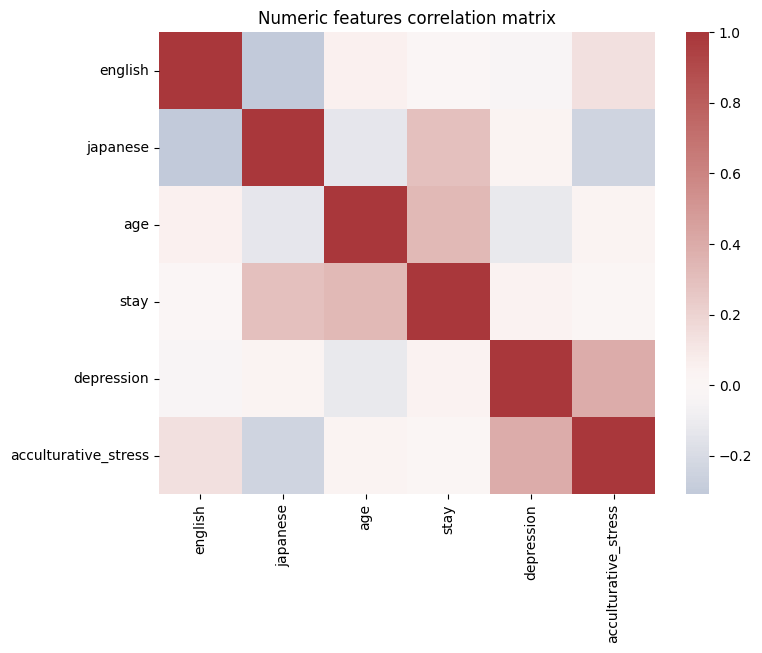

In [ ]:
# Summary of missing data
print(f"Students surveyed: {len(data)}")
missing_summary = data[FEATURES + TARGETS].isna().mean().sort_values(ascending=False)
missing_summary = pd.DataFrame(missing_summary)
missing_summary["missing"] = missing_summary[0].apply(lambda x: f"{x:.1%} missing")

print("\nFeatures and targets with missing data, and their proportions:")
print(missing_summary.loc[missing_summary[0] > 0, "missing"].to_string(header=False))

n_none_missing = len(missing_summary.loc[missing_summary[0] == 0])
print(f"\nThe remaining {n_none_missing} features and targets have no missing data.")

# Correlation heatmap for numeric features
corr = data[NUMERIC_VARS].corr().round(3)
plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap="vlag", center=0, annot=False)
plt.title("Numeric features correlation matrix")
plt.show()

## 3. Model Building

### Construct preprocessing pipelines (numeric + categorical)

In [ ]:
num_pipe = Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())])

cat_pipe = Pipeline(
    [
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

preprocessor = ColumnTransformer(
    [("num", num_pipe, NUMERIC_FEATURES), ("cat", cat_pipe, CAT_FEATURES)], remainder="drop"
)

### Helper - get feature names after ColumnTransformer (for importance mapping)

In [ ]:
def get_feature_names_from_preprocessor(preprocessor):
    """Return list of feature names in the same order as transformed array columns"""
    feature_names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder":
            continue
        if hasattr(trans, "named_steps"):
            # pipeline
            last = list(trans.named_steps.values())[-1]
            if hasattr(last, "get_feature_names_out"):
                fn = last.get_feature_names_out(cols)
                feature_names.extend(list(fn))
            else:
                feature_names.extend(list(cols))
        else:
            feature_names.extend(list(cols))
    return feature_names


def get_feature_names_from_preprocessor(preprocessor):
    """Return list of feature names in the same order as transformed array columns"""
    feature_names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder":
            continue
        if hasattr(trans, "named_steps"):
            # pipeline
            last = list(trans.named_steps.values())[-1]

            if hasattr(last, "get_feature_names_out"):
                fn = last.get_feature_names_out(cols)
                feature_names.extend(list(fn))
            else:
                feature_names.extend(list(cols))
        else:
            feature_names.extend(list(cols))
    return feature_names

### VIF function (run after fitting preprocessor)
Variance Inflation Factor (VIF) quantifies how much a regression coefficient’s variance is inflated due to multicollinearity. It is computed as $ 1/(1 - R^2) $, where $ R^2 $ comes from regressing one feature on all others.

In [ ]:
def compute_vif(preprocessor, X_df):
    """Transform and compute VIF on full preprocessed numeric matrix"""
    X_prep = preprocessor.fit_transform(X_df)
    X_arr = X_prep if isinstance(X_prep, np.ndarray) else X_prep.toarray()
    names = get_feature_names_from_preprocessor(preprocessor)
    vif_df = pd.DataFrame(
        {
            "feature": names,
            "VIF": [variance_inflation_factor(X_arr, i) for i in range(X_arr.shape[1])],
        }
    ).sort_values("VIF", ascending=False)
    return vif_df

### Modeling utilities - Cross-validation evaluation for regression and classification
OK up to and including this cell

In [ ]:
def evaluate_regression_scores(pipe, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    r2 = cross_val_score(pipe, X, y, cv=kf, scoring="r2", n_jobs=-1)
    rmse = -cross_val_score(pipe, X, y, cv=kf, scoring="neg_root_mean_squared_error", n_jobs=-1)
    mae = -cross_val_score(pipe, X, y, cv=kf, scoring="neg_mean_absolute_error", n_jobs=-1)
    return {
        "r2_mean": r2.mean(),
        "r2_std": r2.std(),
        "rmse_mean": rmse.mean(),
        "rmse_std": rmse.std(),
        "mae_mean": mae.mean(),
        "mae_std": mae.std(),
    }


# MUST GO THROUGH THE BELOW STEP BY STEP.
def evaluate_classification_scores(pipe, X, y, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    roc = cross_val_score(pipe, X, y, cv=skf, scoring="roc_auc", n_jobs=-1)
    # PR-AUC approximate via precision_recall_curve on cross_val_predict
    prob = cross_val_predict(pipe, X, y, cv=skf, method="predict_proba", n_jobs=-1)
    # prob[:,1] exists when pipeline returns classifier with predict_proba
    # compute per-fold PR-AUC manually is expensive; approximate with full P-R curve
    pr, re, _ = precision_recall_curve(y, prob[:, 1])
    pr_auc_full = auc(re, pr)
    return {"roc_auc_mean": roc.mean(), "roc_auc_std": roc.std(), "pr_auc": pr_auc_full}

### Define models to run (regression and classification sets)

In [ ]:
regressors = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(random_state=RANDOM_STATE),
    "Lasso": Lasso(random_state=RANDOM_STATE),
    "ElasticNet": ElasticNet(random_state=RANDOM_STATE),
    "RF": RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE),
    "XGB": xgb.XGBRegressor(random_state=RANDOM_STATE, verbosity=0),
}

classifiers = {
    "Logistic": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    # max_iter increased to ensure convergence
    "Logistic_EN": LogisticRegression(
        penalty="elasticnet", solver="saga", l1_ratio=0.5, max_iter=2000, random_state=RANDOM_STATE
    ),  # SAGA solver required for elasticnet
    "RF": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "XGB": xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, verbosity=0),
}

## 4. Running Models

### RUN MODELS - depression (regression target ToDep)

In [ ]:
target_col = TARGETS["depression"]
X = data[FEATURES].copy()
y = pd.to_numeric(data[target_col], errors="coerce").fillna(
    np.nan
)  ### What is this actually doing? Could this be done earlier on in the data cleaning step?
mask = y.notna()  ### This has to be done here, to not needlessly drop data
Xr = X.loc[mask].reset_index(drop=True)
yr = y.loc[mask].reset_index(drop=True)
### Same as above comment

reg_results = {}
for name, model in regressors.items():
    pipe = Pipeline([("pre", preprocessor), ("model", model)])
    result = evaluate_regression_scores(pipe, Xr, yr, cv=5)
    reg_results[name] = result
pd.DataFrame(reg_results).T

### Cell 16: RUN MODELS - suicidal ideation (classification target Suicide)

In [ ]:
target_col = TARGETS["ideation"]
X = data[FEATURES].copy()
y = (
    data[target_col]
    .astype(str)
    .str.lower()
    .map({"yes": 1, "y": 1, "1": 1, "true": 1, "no": 0, "n": 0, "0": 0, "false": 0})
    .fillna(0)
    .astype(int)
)  ### Could this be done earlier on in the data cleaning step?
mask = pd.notna(y)
Xc = X.loc[mask].reset_index(drop=True)
yc = y.loc[mask].reset_index(drop=True)
### Same as above comment


clf_results = {}
for name, model in classifiers.items():
    pipe = Pipeline([("pre", preprocessor), ("model", model)])
    result = evaluate_classification_scores(pipe, Xc, yc, cv=5)
    clf_results[name] = result
pd.DataFrame(clf_results).T